# Importok

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import scipy.stats as stats
import graphviz

from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.tree import export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import kstest
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Adatok letöltése

Az HTRU2 adatbázis a High Time Resolution Universe Survey során gyűjtött pulzárjelölt adatokat tartalmazza. A pulzárok gyorsan forgó neutroncsillagok, melyek rádiójelet bocsátanak ki, ezek periodikusan ismétlődnek, és földi teleszkópokkal észlelhetők. A jelöltek többsége azonban nem valódi pulzár, hanem zaj vagy rádiófrekvenciás interferencia következménye, így nehéz azonosítani a valódi pulzárokat. Az adatbázis 16259 hamis és 1639 valódi pulzár példát tartalmaz, amelyeket emberi annotátorok ellenőriztek.

In [2]:
htru2 = fetch_ucirepo(id=372)

In [3]:
X = htru2.data.features
X

,Profile_mean,Profile_stdev,Profile_skewness,Profile_kurtosis,DM_mean,DM_stdev,DM_skewness,DM_kurtosis
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306
...,...,...,...,...,...,...,...,...
17893,136.429688,59.847421,-0.187846,-0.738123,1.296823,12.166062,15.450260,285.931022
17894,122.554688,49.485605,0.127978,0.323061,16.409699,44.626893,2.945244,8.297092
17895,119.335938,59.935939,0.159363,-0.743025,21.430602,58.872000,2.499517,4.595173
17896,114.507812,53.902400,0.201161,-0.024789,1.946488,13.381731,10.007967,134.238910


In [4]:
type(X)

pandas.core.frame.DataFrame

In [5]:
feature_cimkek = list(X.columns)
feature_cimkek

['Profile_mean',
 'Profile_stdev',
 'Profile_skewness',
 'Profile_kurtosis',
 'DM_mean',
 'DM_stdev',
 'DM_skewness',
 'DM_kurtosis']

**Profile_mean** </br>
A kvazár rádiófrekvenciás profiljának átlagos intenzitása, azaz az adott hullámforma középértéke.

**Profile_stdev** </br>
A profil intenzitásának szórása, ami azt mutatja, mennyire ingadozik az érték az átlag körül.

**Profile_skewness** </br>
A profil aszimmetriáját jelzi.

**Profile_kurtosis** </br>
A profil csúcsosságát vagy laposságát mutatja az eloszlás normálishoz viszonyított alakja alapján.

**DM_mean** </br>
A diszperziós mérték (Dispersion Measure) átlagos értéke, amely megmutatja, mennyi anyagon haladt át a jel.

**DM_stdev** </br>
A diszperziós mérték szórása, azaz mennyire változó ez az érték a mérések során.

**DM_skewness** </br>
A diszperziós mérték eloszlásának aszimmetriáját mutatja, hasonlóan a profilhoz.

**DM_kurtosis** </br>
A diszperziós mérték eloszlásának csúcsosságát vagy laposságát jellemzi.

In [6]:
y = htru2.data.targets
y

,class
0,0
1,0
2,0
3,0
4,0
...,...
17893,0
17894,0
17895,0
17896,0


In [7]:
type(y)

pandas.core.frame.DataFrame

# EDA

In [8]:
X.describe()

,Profile_mean,Profile_stdev,Profile_skewness,Profile_kurtosis,DM_mean,DM_stdev,DM_skewness,DM_kurtosis
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309330
max,192.617188,98.778911,8.069522,68.101622,223.392141,110.642211,34.539844,1191.000837


In [9]:
hianyzo_ertekek_X = X.isnull().sum()
hianyzo_ertekek_X

Profile_mean        0
Profile_stdev       0
Profile_skewness    0
Profile_kurtosis    0
DM_mean             0
DM_stdev            0
DM_skewness         0
DM_kurtosis         0
dtype: int64

In [10]:
y.describe()

,class
count,17898.000000
mean,0.091574
std,0.288432
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [11]:
y["class"].unique()

array([0, 1])

**0-s osztály** </br>
A "zaj" vagy nem-pulzár jelek (ezekből van több).

**1-es osztály** </br>
A keresett pulzárok (ritkább, specifikus jelek).

In [12]:
y["class"].value_counts()

class
0    16259
1     1639
Name: count, dtype: int64

Az adathalmaz nagyon el van tolódva a 0 osztály felé, tízszer annyi 0 osztályt tartalmaz, mint 1-et.

In [13]:
hianyzo_ertekek_y = y.isnull().sum()
hianyzo_ertekek_y

class    0
dtype: int64

In [14]:
osztaly_cimke = list(y.columns)
osztaly_cimke

['class']

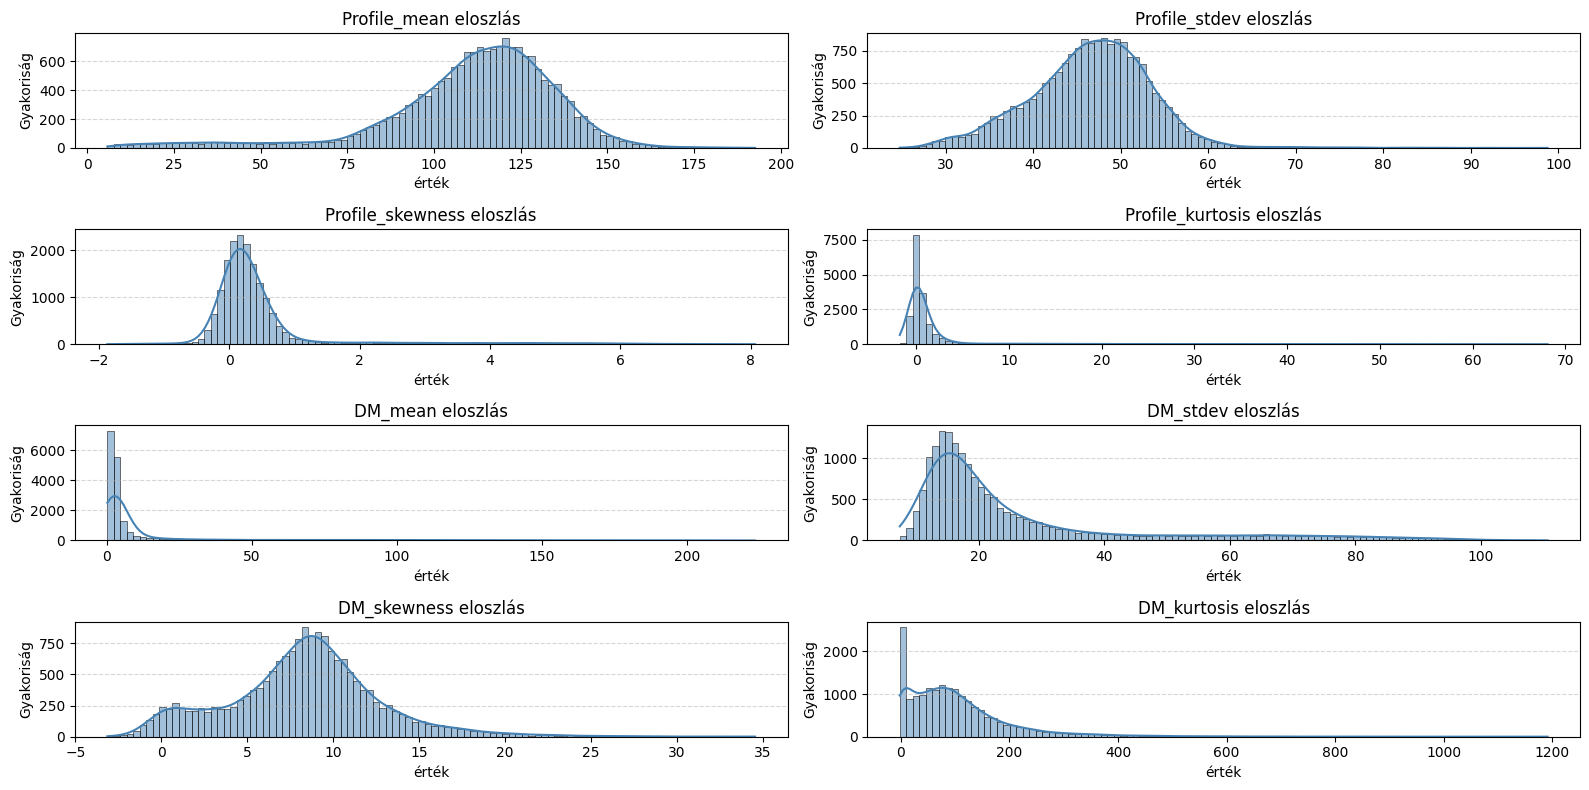

In [15]:
for i, adat in enumerate(feature_cimkek):
    j = i % len(feature_cimkek)
    if j == 0:
        fig, axes = plt.subplots(len(feature_cimkek) // 2, 2, figsize=(16, 8))
        axes = axes.flatten()
    ax = axes[j]
    sb.histplot(data=X, x=adat, kde=True, color="steelblue", ax=ax, bins=100)
    ax.set_title(f"{adat} eloszlás", fontsize=12)
    ax.set_xlabel("érték")
    ax.set_ylabel("Gyakoriság")
    ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

Mivel tudjuk, hogy az adathalmazban a "zaj" (0-s osztály) a bemeneti adatok 90%-át teszi ki, ezek a grafikonok elsősorban a 0-s osztály (zaj) eloszlását tükrözik. A ritka pulzárok (1-es osztály) adatai feltehetően elvesznek a "farkakban", a szélsőségesnek tűnő értékekben vagy a kettős csúcsokban.

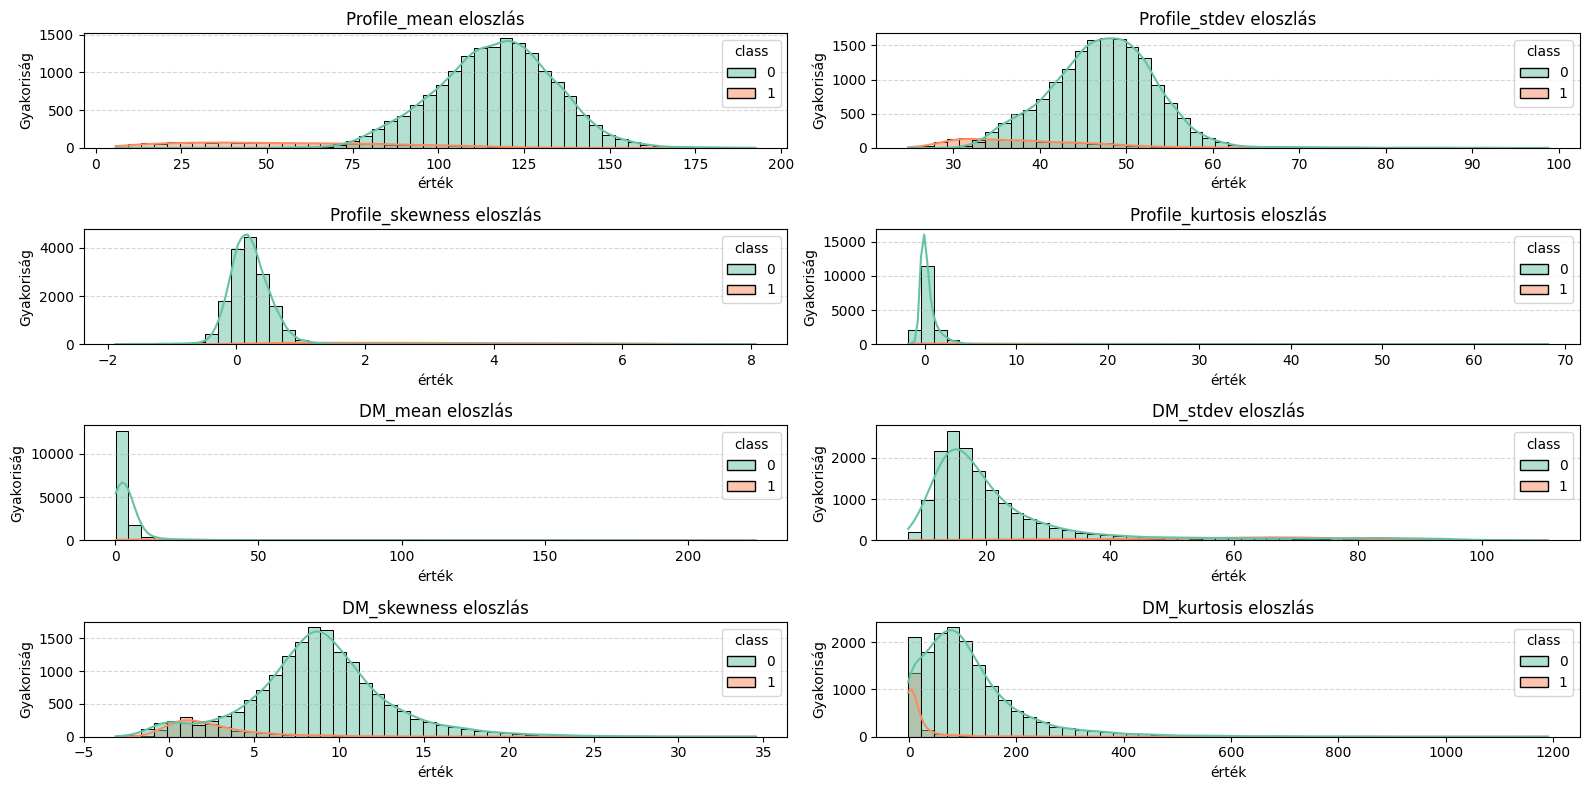

In [16]:
temp = pd.concat([X, y], axis=1)

for i, adat in enumerate(feature_cimkek):
    j = i % len(feature_cimkek)
    if j == 0:
        fig, axes = plt.subplots(len(feature_cimkek) // 2, 2, figsize=(16, 8))
        axes = axes.flatten()
    ax = axes[j]
    sb.histplot(data=temp, x=adat, hue='class', kde=True, ax=ax, bins=50, palette='Set2')
    ax.set_title(f"{adat} eloszlás", fontsize=12)
    ax.set_xlabel("érték")
    ax.set_ylabel("Gyakoriság")
    ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

Az előző feltételezéseimet ez megerősíti:
- a grafikonok elsősorban a 0-s osztály (zaj) eloszlását tükrözik
- a ritka pulzárok (1-es osztály) adatai a "farkakban" (pl. Profile_mean) és dupla csúcsokban jelennek meg (pl. DM_skewness)

Viszont a DM skewness és a DM kurtosis két csúcspontját a két osztály eltérő hisztogramja megmagyarázza.

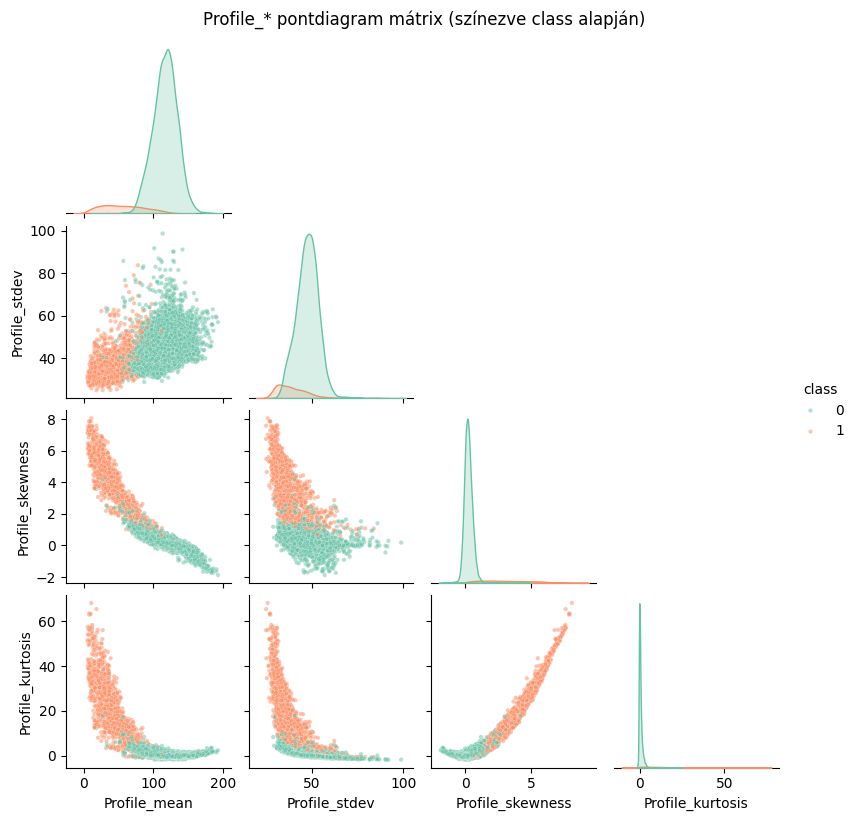

In [17]:
profile_cimkek = [c for c in feature_cimkek if c.startswith('Profile')]
sb.pairplot(pd.concat([X[profile_cimkek], y], axis=1), hue='class', diag_kind='kde', corner=True, palette='Set2', plot_kws={'s': 10, 'alpha': 0.5}, height=2)
plt.suptitle("Profile_* pontdiagram mátrix (színezve class alapján)", y=1.02)
plt.show()

Itt szerintem több változó is együtt mozog, ha nem is lineárisan. Például a skewness értékének kövekedésével a kurtosis is növekszik, vagy pl a mean növekedésével a skewness csökkenő tendenciát mutat. Azonban az egyes osztályok eléggé elkülönülnek egymástól, máshol, másként csoportosulnak.

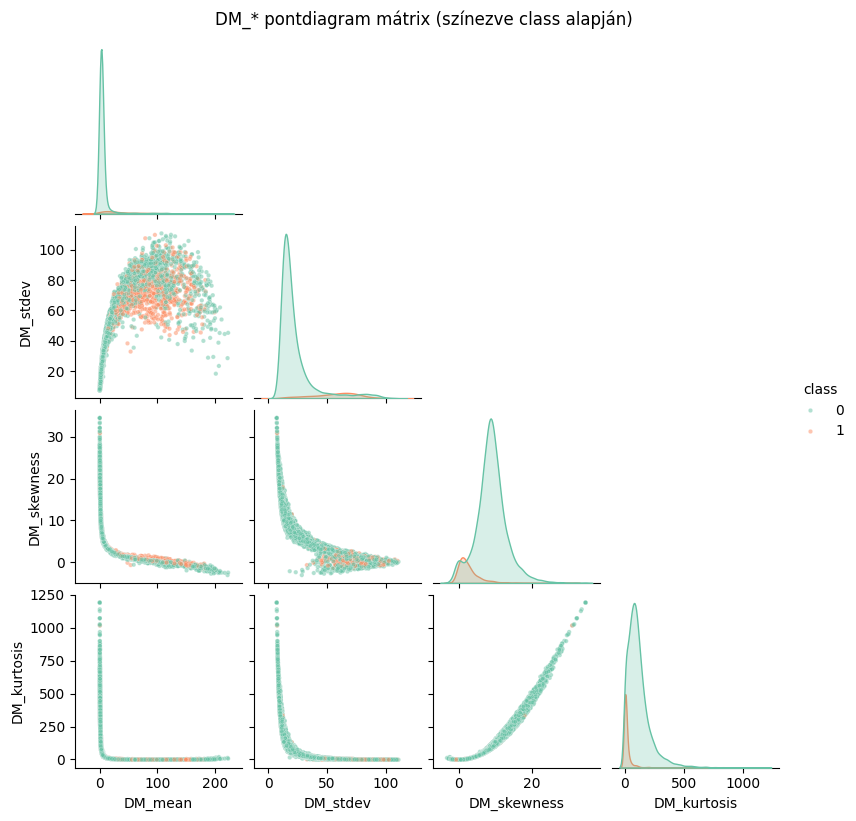

In [18]:
dm_cimkek = [c for c in feature_cimkek if c.startswith('DM')]
sb.pairplot(pd.concat([X[dm_cimkek], y], axis=1), hue="class", diag_kind="kde", corner=True, palette="Set2", plot_kws={"s": 10, "alpha": 0.5}, height=2)
plt.suptitle("DM_* pontdiagram mátrix (színezve class alapján)", y=1.02)
plt.show()

Míg a profile értékeknél "felhők"-be csoportosultak az adatok itt többnyire vékony vonalak jelennek meg. A skewness/kurtosis szinte teljesen együtt mozog. A mean 0 közeli értéke esetén azonban kurtosis és a skewness szinte bármekkora értéket felvehet.

Másrészt, itt a narancs pontok mintha inkább csak egy-egy pontba tömörülnének, szinte alig láthatóak az ábrán. Önmagukban a DM változók nehezebben választják szét a pulzárokat a zajtól, mert a pulzárok adatai (narancs) gyakran lefedik a zaj (zöld) területét is.

Összességében inkább a Profile változók mondják meg, hogy "úgy néz-e ki, mint egy pulzár", a DM változók pedig azt teszik hozzá, hogy "távolról jön-e a jel" (a zajnak szinte nincs diszperziója, ami logikus, hiszen nem távoli űrből jön, hanem feltehetően helyi zavar). A kettő együtt adja a legjobb eredményt feltehetően.

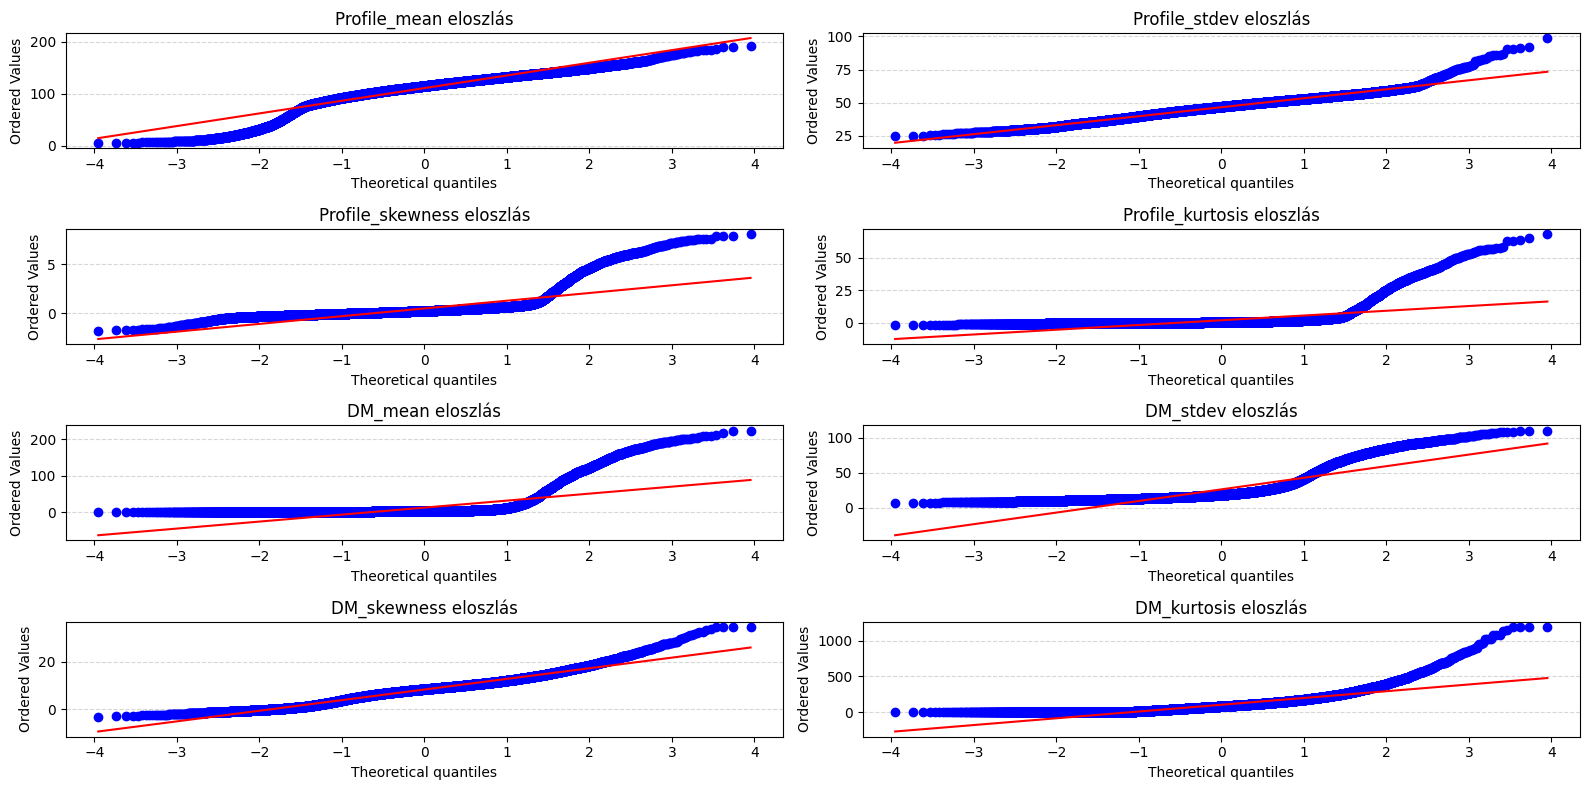

In [19]:
for i, adat in enumerate(feature_cimkek):
    j = i % len(feature_cimkek)
    if j == 0:
        fig, axes = plt.subplots(len(feature_cimkek) // 2, 2, figsize=(16, 8))
        axes = axes.flatten()
    ax = axes[j]
    stats.probplot(X[adat], dist="norm", plot=ax)
    ax.set_title(f"{adat} eloszlás", fontsize=12)
    ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

Az adatok egyáltalán nem követik a normális eloszlást. Minden egyes ábránál jelentős eltérés van a piros vonaltól.

Nem használhatok olyan algoritmusokat átalakítások nélkül, amik normális eloszlást feltételeznek. Robusztus modellek kellenek: a döntési fák, a Random Forest vagy az XGBoost sokkal jobban kezelik az ilyen "csúnya", nem normális eloszlású és kiugró értékekkel teli adatokat.

A Q-Q plotok azt mutatják, hogy az adathalmaz tele van aszimmetriával és kiugró értékekkel (valószínűleg ezek a keresett pulzárok jelei lehetnek???), és távol áll a "szép" haranggörbétől.

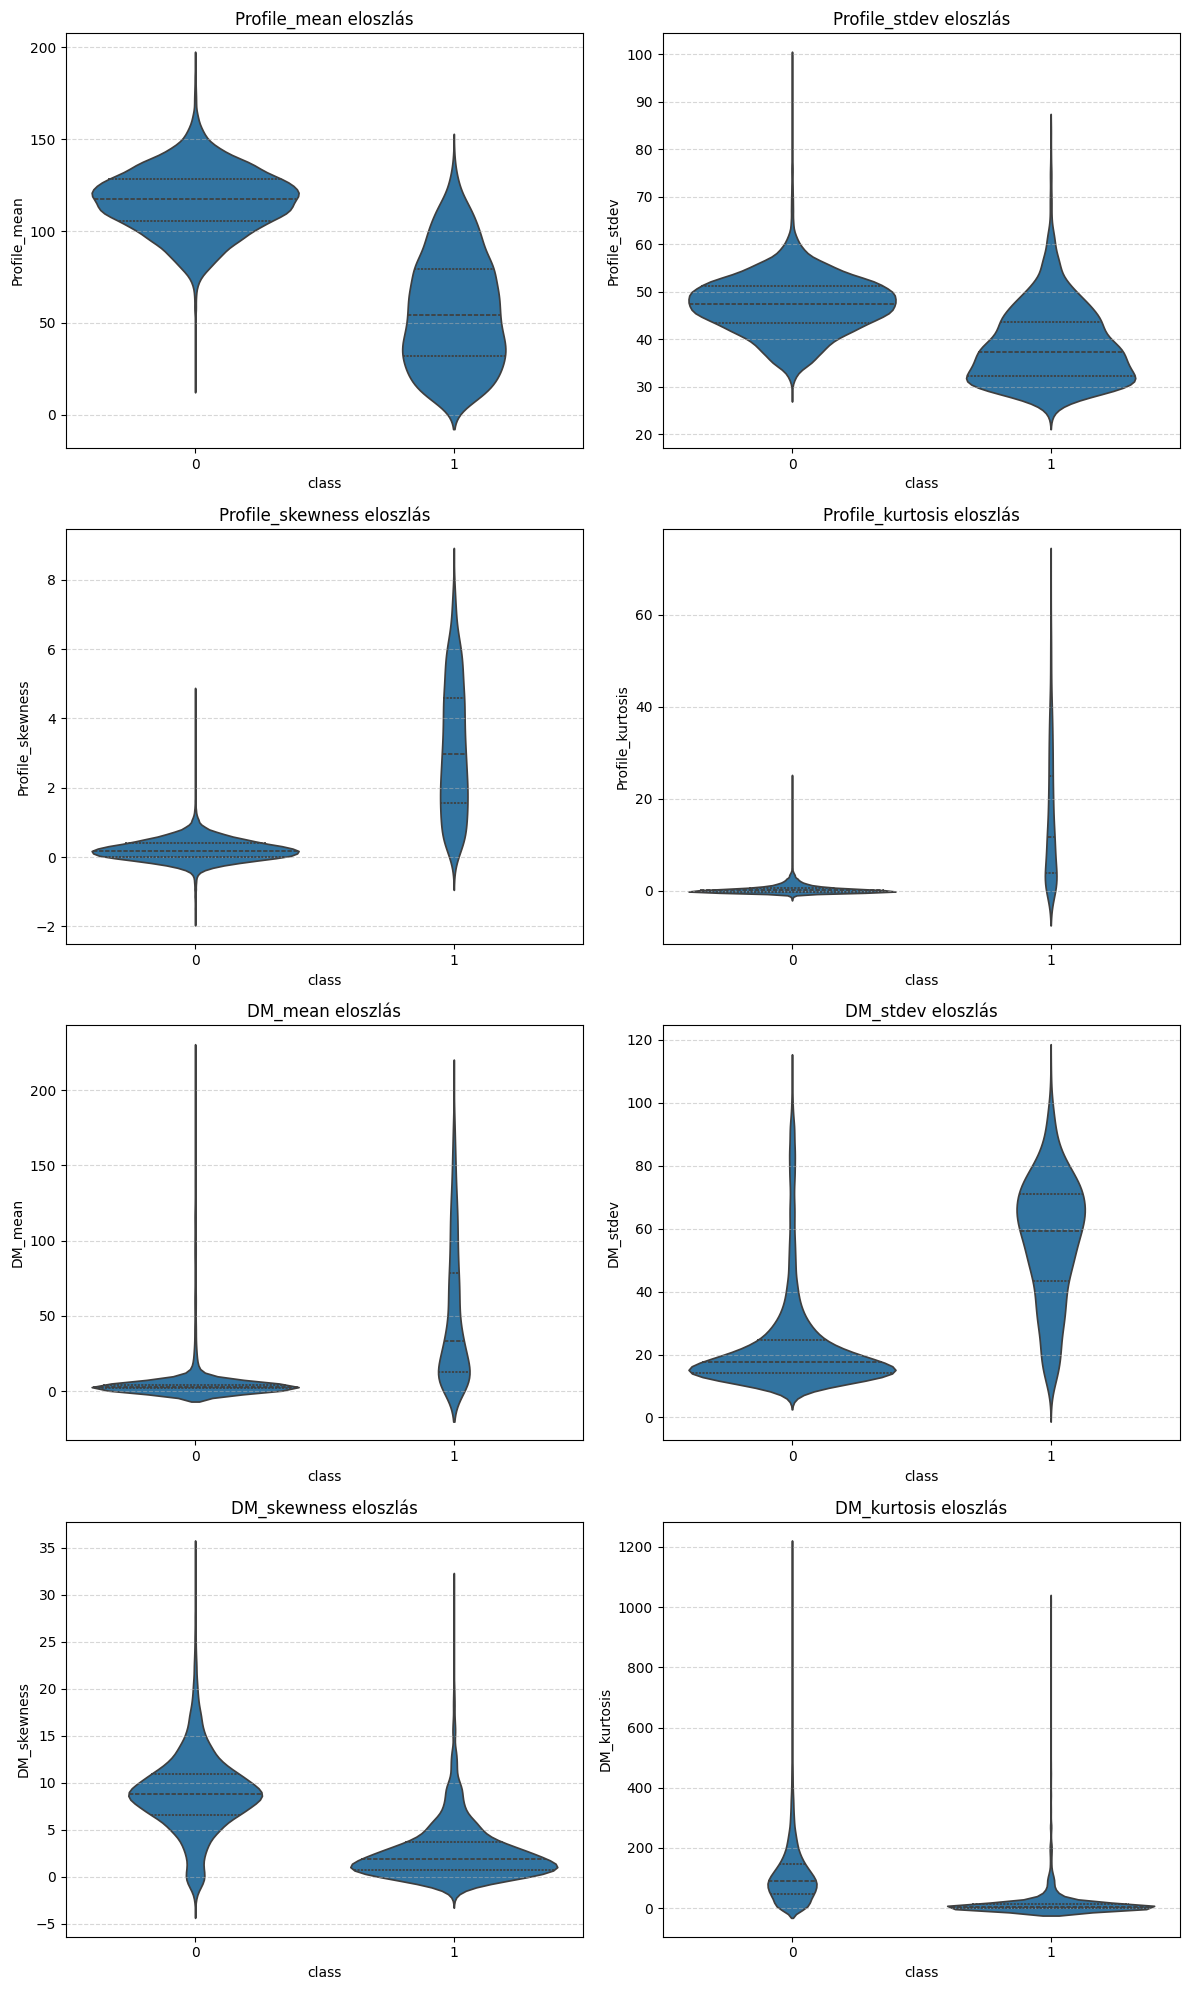

In [20]:
for i, adat in enumerate(feature_cimkek):
    j = i % len(feature_cimkek)
    if j == 0:
        fig, axes = plt.subplots(len(feature_cimkek) // 2, 2, figsize=(12, 20))
        axes = axes.flatten()
    ax = axes[j]
    sb.violinplot(data=pd.concat([X, y], axis=1), x="class", y=adat, inner="quartile", ax=ax) 
    ax.set_title(f"{adat} eloszlás", fontsize=12)
    ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

**Profile_mean (Átlag)**
- 0-s osztály: Magasabb értékek körül tömörül (kb. 100-120).
- 1-es osztály: Alacsonyabb értékek (kb. 40-60).
- A két osztály jól elkülönül, a pulzárok profiljának átlaga alacsonyabb.

**Profile_stdev (Szórás)**
- Kisebb az eltérés, de a 0-s osztálynak valamivel magasabb és szélesebb eloszlása van, mint az 1-esnek.

**Profile_skewness (Ferdeség)**
- 0-s osztály: 0 közelében van, szimmetrikus eloszlás.
- 1-es osztály: Magas pozitív értékek.
- Ez egy nagyon erős megkülönböztető jellemző. A pulzárok jele aszimmetrikus.

**Profile_kurtosis (Csúcsosság)**
- Hasonló a ferdeséghez: a 0-s osztály lapos (0 körüli), míg az 1-es osztály nagyon csúcsos (magas értékek).
- Ez is élesen szétválasztja a két csoportot.

**DM_mean és DM_stdev**
- 0-s osztály: Nagyon kicsi értékeknél, a 0 közelében tömörülnek (a hegedű alja széles).
- 1-es osztály: Sokkal nagyobb szórást és magasabb átlagértékeket mutatnak.
- A pulzárok (1) DM értékei változatosabbak és magasabbak.

**DM_skewness és DM_kurtosis**
- Itt a helyzet fordított, mint a Profile esetében. A 0-s osztály mutat nagyobb értékeket és szórást, míg az 1-es osztály értékei alacsonyabb tartományban mozognak.

**A két osztály eloszlásai jelentősen eltérnek** </br>
Szinte minden változón jól látható, hogy a 0 és 1 osztály eloszlásai nem fedik egymást teljesen. Ez azt jelenti, hogy az adott jellemzők valóban informatívak lehetnek az osztály elkülönítésére, az adathalmaz jó alap egy klasszifikációs modellhez.

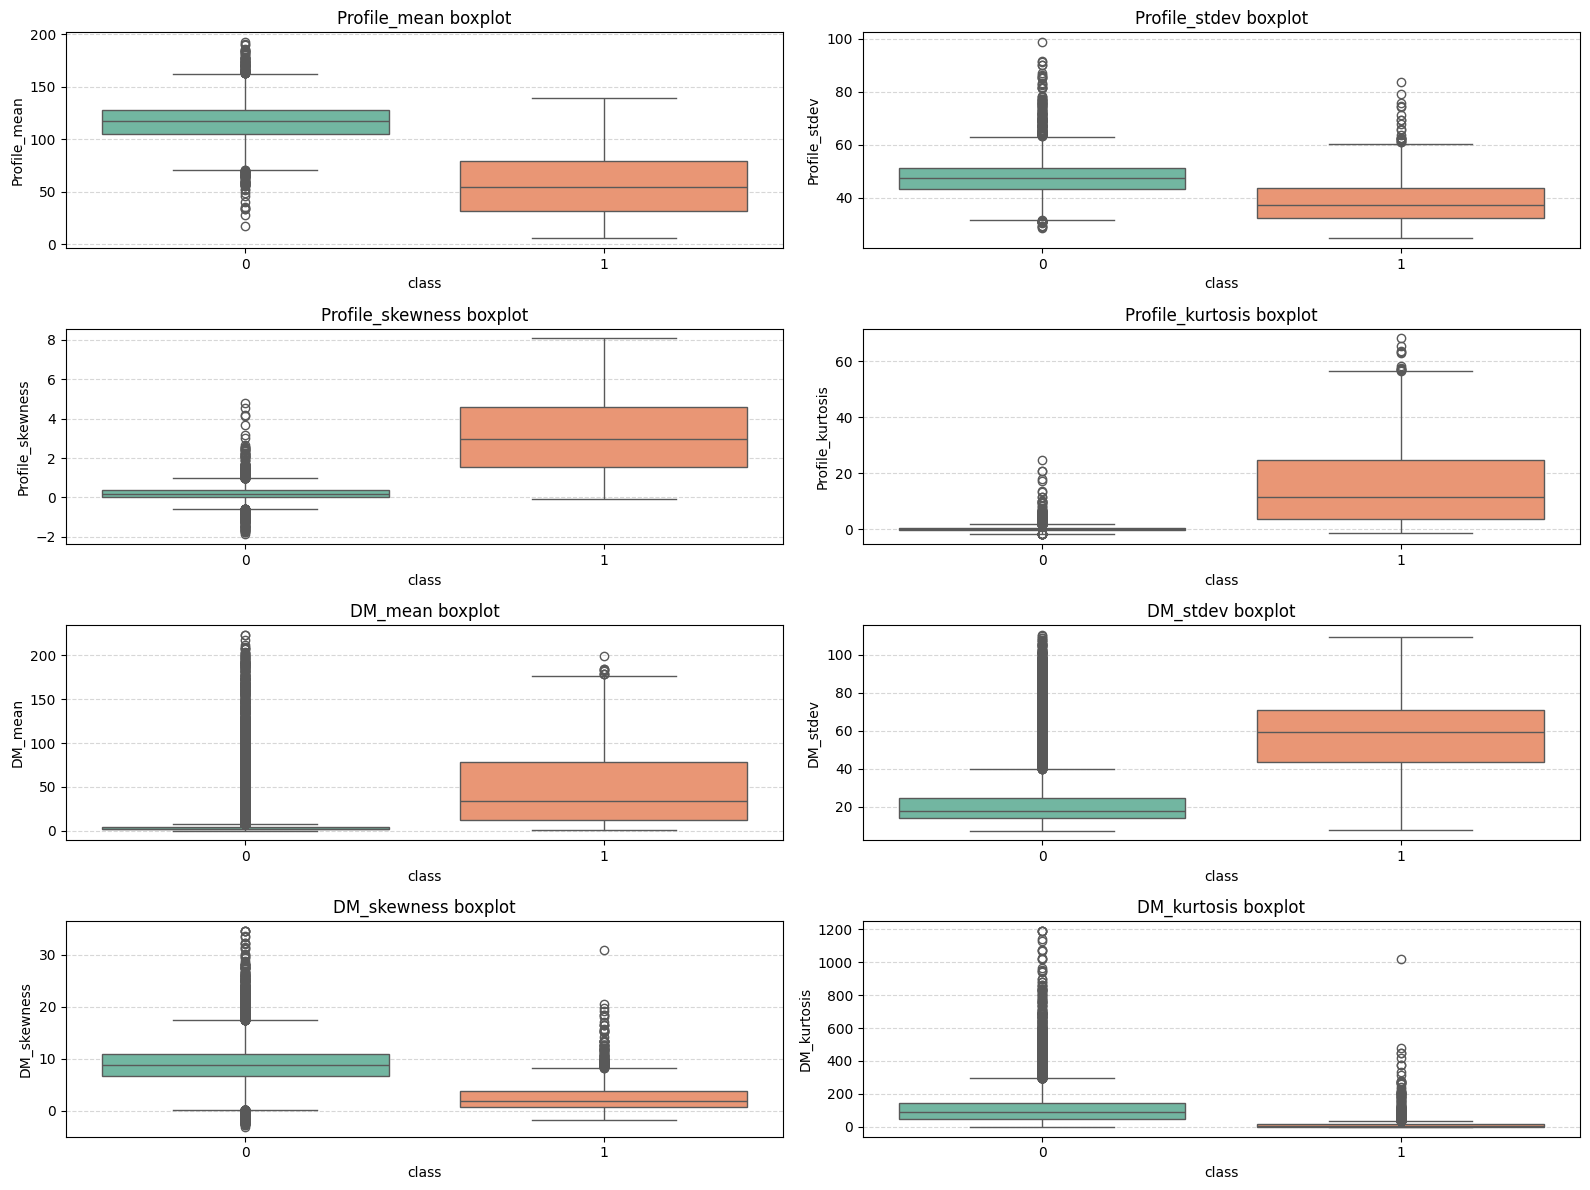

In [21]:
temp = pd.concat([X, y], axis=1)

fig, axes = plt.subplots(4, 2, figsize=(16, 12))
axes = axes.flatten()

for i, adat in enumerate(feature_cimkek):
    sb.boxplot(data=temp, x="class", y=adat, hue="class", palette="Set2", legend=False, ax=axes[i])
    axes[i].set_title(f"{adat} boxplot", fontsize=12)
    axes[i].grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

A boxplotok alapján a szélsőértékek extrémek és torzítják a skálát és főleg a class 0 (nem pulzár) esetében jelentősek. Legtöbb esetben a pulzárokat leíró adatok interquartilis terjedelme nagyobb és kevesebb outliert tartalmaznak, míg a nem pulzárként cimkézett adatok bár stabilabbak, jobban tömörülnek egy érték körül, de sokkal nagyobbak a kiugró értékek és sokkal több is van belőlük.

Talán a legérdekesebb adatok a Profile_skewness és/vagy a Profile_kurtosis lehetne, mert itt az értékek annyira elkülönülnek egymástól, hogy akár 1-1 vágással is el tudnák különíteni az adatokat.

# Összefüggés vizsgálat

A Pearson-korreláció ebben az esetben nem lesz megfelelő, mert az adatok egyáltalán nem követnek normális eloszlást. Ezért a Spearman-féle rangkorrelációt vizsgálom.

In [22]:
X.corr(method='spearman').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=None)

,Profile_mean,Profile_stdev,Profile_skewness,Profile_kurtosis,DM_mean,DM_stdev,DM_skewness,DM_kurtosis
Profile_mean,1.0,0.5,-0.88,-0.64,-0.077,-0.09,0.081,0.085
Profile_stdev,0.5,1.0,-0.5,-0.88,0.0071,-0.0046,0.0026,0.0054
Profile_skewness,-0.88,-0.5,1.0,0.66,0.087,0.1,-0.089,-0.093
Profile_kurtosis,-0.64,-0.88,0.66,1.0,0.065,0.078,-0.072,-0.075
DM_mean,-0.077,0.0071,0.087,0.065,1.0,0.95,-0.99,-0.99
DM_stdev,-0.09,-0.0046,0.1,0.078,0.95,1.0,-0.95,-0.97
DM_skewness,0.081,0.0026,-0.089,-0.072,-0.99,-0.95,1.0,0.99
DM_kurtosis,0.085,0.0054,-0.093,-0.075,-0.99,-0.97,0.99,1.0


**Profile_mean – Profile_skewness**
- –0.88, ez erős negatív írányú kapcsolat, az egyik változó növekedésével a másik csökken

**Profile_stdev – Profile_kurtosis**
- –0.88, ez erős negatív írányú kapcsolat

**Profile_kurtosis -  Profile_mean**
- -0.635, közepes negatív irányú kapcsolat

**Profile_stdev - Profile_skewness**
- -0.5, közepes negatív irányú kapcsolat

**Profile_skewness - Profile_kurtosis**
- 0.66, közepes pozitív irányú kapcsolat, az egyik változó kövekedésével a másik is növekszik

**Profile_mean - Profile_stdev**
- 0.5, közepes pozitív irányú kapcsolat

**DM adatok**
- Tulajdonképpen a diszperziós értéket leíró adatok közül bármely kettőt vesszük, azok erősen összefüggésben vannak egymással. Talán a 4 változó helyettesíthető csak eggyel is? Mert eléggé úgy tűnik, hogy ugyan azt az információt írják le. Aminek egyébként van értelme, mert ez a 4 változó azt írja le, hogy a jel a Földről származik vagy sem (pl. rádiófrekvenciás zaj a földről).

**DM és Profile**
- A korrelációs mátrix alapján mindenhol elmondható, hogy a két adatcsoportot leíró változók között nincs összefüggés.

# Adattisztítás

## Outlierek

A statisztikai adatok alapján egyértelmű, hogy az outlierek eltávolítása szükséges, de ez nem olyan egyszerű, mert a pulzár osztály minden outlierét nem távolíthatom el . Azért nem, mert ezek az értékes adatok, kevés van belőlük és egyáltalán nem biztos, hogy outlierek, lehet, hogy egy a többi pulzártól eltérő de valós adat, ami akár egy különleges felfedezés is lehet. Ezért a zajból fogom eltávolítani az outliereket, mert abból sok adat van és azokból adatok eltávolítása nem fogja tovább rontani az adathalmaz kiegyensúlyozatlanságát. A pulzár adatok esetén csak a DM_kurtosis és DM_skewness esetén nagyon kiugró egyetlen adat eltávolítását tervezem.

In [23]:
def remove_outliers_iqr(X, y, multiplier=1.5):
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((X < (Q1 - multiplier * IQR)) | (X > (Q3 + multiplier * IQR))).any(axis=1)
    return X[mask], y[mask]

In [24]:
X_class0 = X[y['class'] == 0]
y_class0 = y[y['class'] == 0]

X_class1 = X[y['class'] == 1]
y_class1 = y[y['class'] == 1]

X_clean_class1, y_clean_class1 = remove_outliers_iqr(X_class0, y_class0, 1.5)

X_clean = pd.concat([X_clean_class1, X_class1])
y_clean = pd.concat([y_clean_class1, y_class1])

In [25]:
torlendo_indexek = X_clean.query("DM_skewness > 25 and DM_kurtosis > 500").index
X_clean = X_clean.drop(torlendo_indexek)
y_clean = y_clean.drop(torlendo_indexek)

In [26]:
X_clean.describe()

,Profile_mean,Profile_stdev,Profile_skewness,Profile_kurtosis,DM_mean,DM_stdev,DM_skewness,DM_kurtosis
count,13893.000000,13893.000000,13893.000000,13893.000000,13893.000000,13893.000000,13893.000000,13893.000000
mean,110.499665,46.537455,0.534559,2.028666,8.404799,22.887191,8.479562,97.914794
std,26.323081,6.168195,1.170556,6.919082,21.749256,14.921656,3.290251,65.619742
min,5.812500,24.772042,-0.563544,-1.185706,0.678930,9.343991,-1.862320,-1.874683
25%,102.242188,42.810406,0.035134,-0.178352,1.969064,14.582813,6.742438,49.926676
50%,115.179688,46.952870,0.221454,0.190296,2.689799,17.874462,8.658363,88.367507
75%,126.593750,50.772802,0.449825,0.806291,4.120401,24.038398,10.565953,135.612062
max,162.476562,83.796909,8.069522,68.101622,199.577759,109.655345,20.430019,479.670964


In [27]:
y["class"].value_counts(), y_clean["class"].value_counts()

(class
 0    16259
 1     1639
 Name: count, dtype: int64,
 class
 0    12255
 1     1638
 Name: count, dtype: int64)

Az outlierek eltávolítása a pulzár osztálybol (class=1) 1 elemet távolított el, de a zaj (class=0) osztály elemeinek száma 4004-el csökkent. Ennek előnye az outlierek eltávolításán túl, hogy nem csak a kiegyensúlyozatlanság csökkent kis mértékben, de megmaradtak az értékes osztály adatai.

## Normalitás

In [28]:
def normalitas_ellenorzes(df):
    results = []
    
    for col in df.columns:
        data = df[col]
        stat, p = kstest(data, 'norm', args=(np.mean(data), np.std(data)))
        
        results.append({
            'Változó': col,
            'P-érték': p,
            'Normális eloszlású?': 'IGEN' if p > 0.05 else 'NEM',
            'Statisztika': stat
        })
    
    results_df = pd.DataFrame(results)
    return results_df

In [29]:
normalitas_eredmenyek = normalitas_ellenorzes(X_clean)
normalitas_eredmenyek

,Változó,P-érték,Normális eloszlású?,Statisztika
0,Profile_mean,1.816226e-199,NEM,0.128183
1,Profile_stdev,1.530658e-13,NEM,0.032953
2,Profile_skewness,0.000000e+00,NEM,0.320986
3,Profile_kurtosis,0.000000e+00,NEM,0.404620
4,DM_mean,0.000000e+00,NEM,0.414242
5,DM_stdev,0.000000e+00,NEM,0.221867
6,DM_skewness,6.960924e-30,NEM,0.049383
7,DM_kurtosis,3.090708e-50,NEM,0.064207


Ez megerősíti az ábrákon látottakat, hogy egyik változó sem normális eloszlású. Ennek kezelésére a power transformert használom a yeo-johnsom módszerrel, mert negatív értékek is vannak az adathalmazban.

In [30]:
pt = PowerTransformer(method='yeo-johnson', standardize=True)
X_trans = pt.fit_transform(X_clean)
X_clean = pd.DataFrame(X_trans, columns=X_clean.columns, index=X_clean.index)

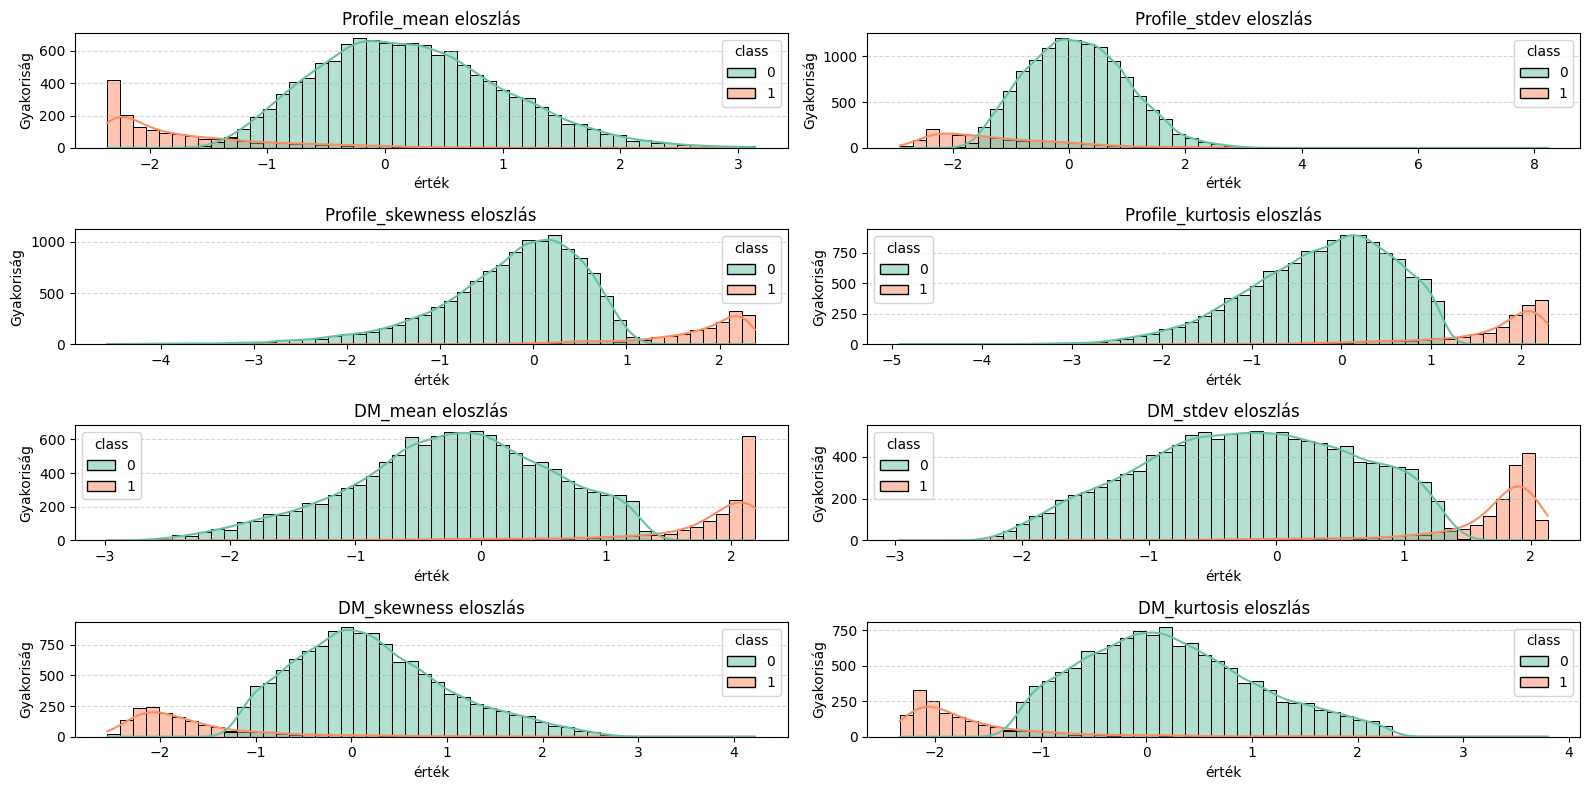

In [31]:
temp = pd.concat([X_clean, y_clean], axis=1)

for i, adat in enumerate(feature_cimkek):
    j = i % len(feature_cimkek)
    if j == 0:
        fig, axes = plt.subplots(len(feature_cimkek) // 2, 2, figsize=(16, 8))
        axes = axes.flatten()
    ax = axes[j]
    sb.histplot(data=temp, x=adat, hue='class', kde=True, ax=ax, bins=50, palette='Set2')
    ax.set_title(f"{adat} eloszlás", fontsize=12)
    ax.set_xlabel("érték")
    ax.set_ylabel("Gyakoriság")
    ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

A tökéletes normális eloszlást nem tudtam ezzel elérni, de ennek oka az ábrákon is látható, mivel mostmár nagyon elkülönülnek a két osztály grafikonjai.

## Skálázás

A RobustScaler a mediánt és az IQR-t használja a skálázáshoz. Így a szélső értékek nem fogják "összenyomni" a görbe közepét.

In [32]:
rs = RobustScaler()
X_clean_rs = rs.fit_transform(X_clean)
X_clean = pd.DataFrame(X_clean_rs, columns=X_clean.columns, index=X_clean.index)

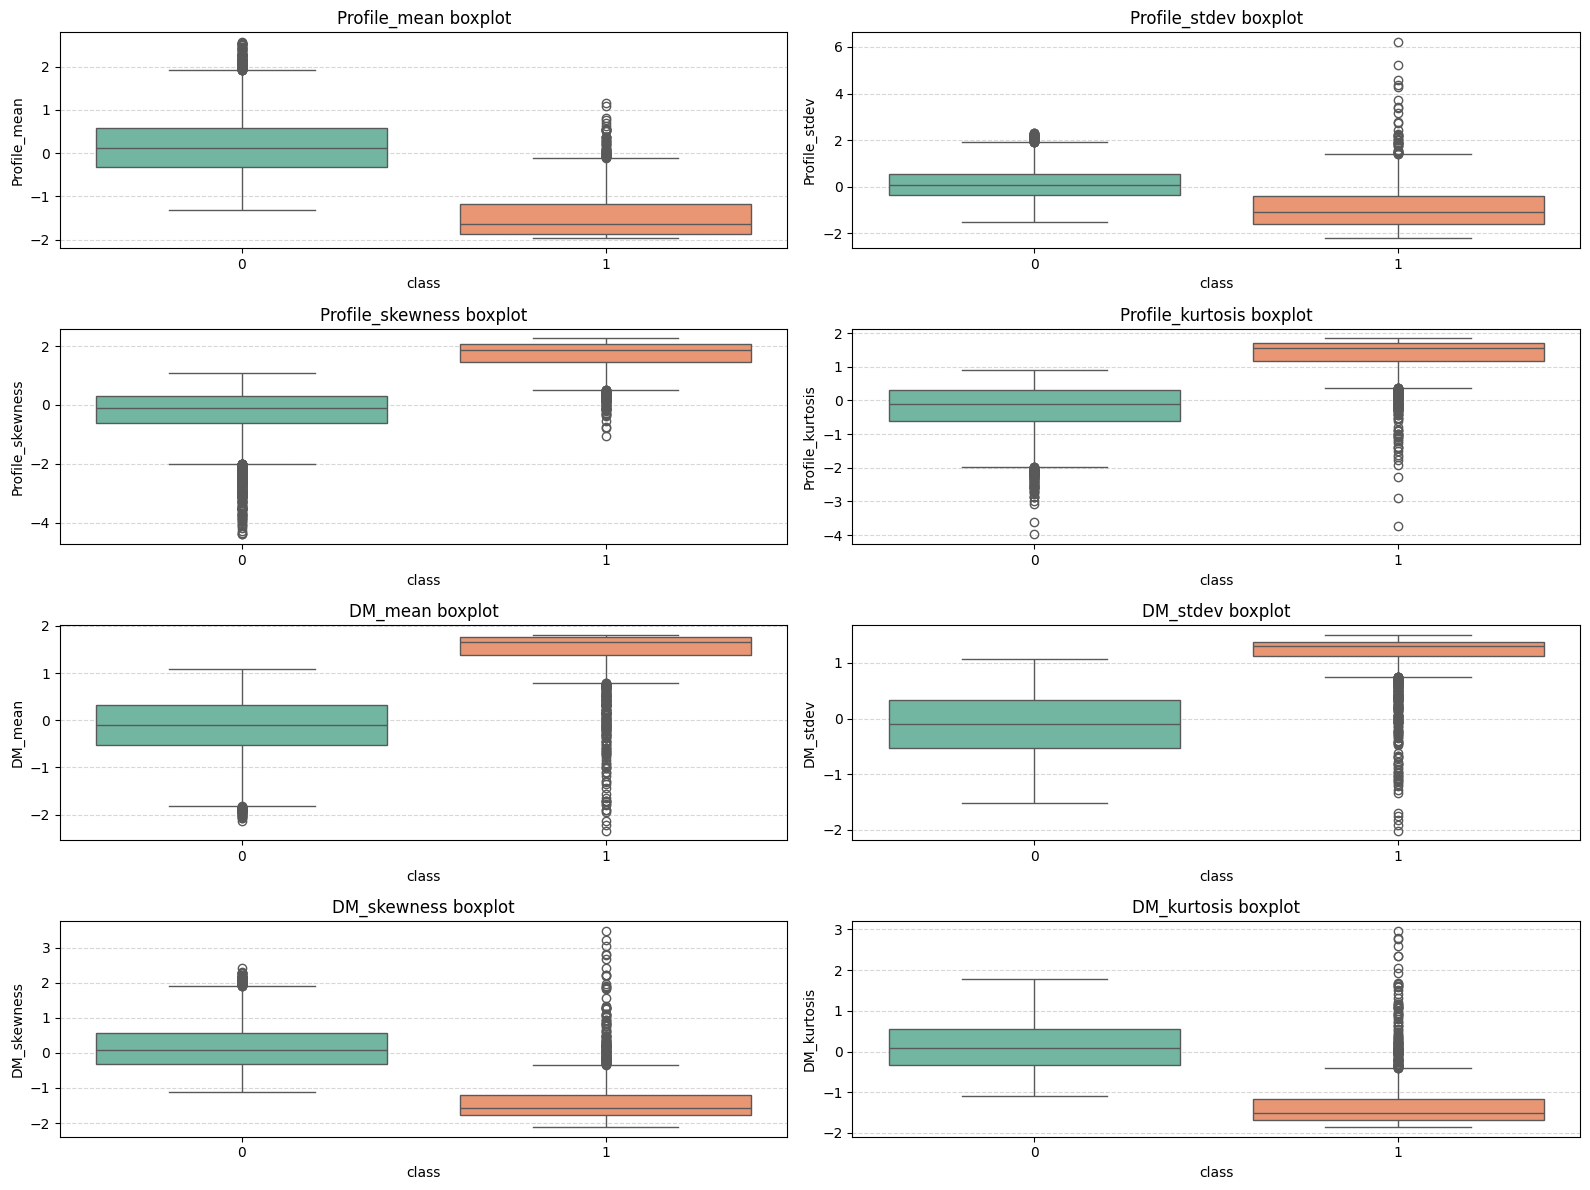

In [33]:
temp = pd.concat([X_clean, y_clean], axis=1)

fig, axes = plt.subplots(4, 2, figsize=(16, 12))
axes = axes.flatten()

for i, adat in enumerate(feature_cimkek):
    sb.boxplot(data=temp, x="class", y=adat, hue="class", palette="Set2", legend=False, ax=axes[i])
    axes[i].set_title(f"{adat} boxplot", fontsize=12)
    axes[i].grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

# Osztályozás

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean, y_clean, test_size=0.33, stratify=y_clean)

## Döntési fa (nyers adatok)

Ezt kizárólag csak azért csinálom meg a nyers adatokon, hogy legyen valami kiinduló alapom, "baseline" az összehasonlításhoz (hogy pl. mennyit számítot az adatok átalakítása). Ezt elvileg megtehetem, mert a döntési fa nem érzékeny az outlierekre és nem követeli meg a normalitást és a skálázást.

In [35]:
dtc = DecisionTreeClassifier()

In [36]:
dtc.fit(X_train,y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [37]:
y_pred = dtc.predict(X_test)

In [38]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Sensitivity:", recall_score(y_test, y_pred))
print("Specificity:", recall_score(y_test, y_pred, pos_label=0))
print("F1:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred))

Accuracy: 0.9703741323853056
Sensitivity: 0.8299445471349353
Specificity: 0.9845322400298173
F1: 0.83690587138863
AUC: 0.9072383935823762


Ez a pontosság adat akár magasnak is mondható, de nagyon félrevezető, mert az adathalmaz nem kiegyensúlyozott.

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5366
           1       0.84      0.83      0.84       541

    accuracy                           0.97      5907
   macro avg       0.91      0.91      0.91      5907
weighted avg       0.97      0.97      0.97      5907



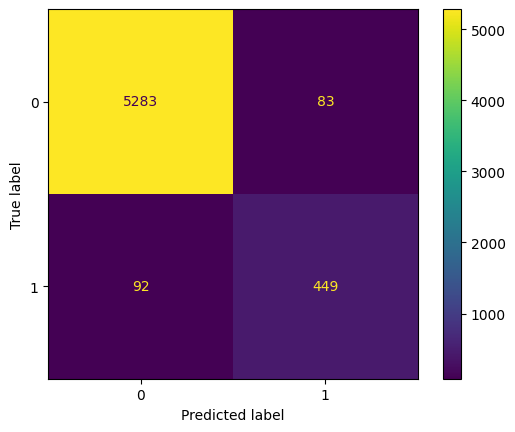

In [40]:
confmatrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=confmatrix).plot()

A modell kiválóan teljesít a nagyobb osztály esetében. Szinte minden 0-s predikció pontos, és az esetek szinte mindegyikét megtalálja. A kisebb osztály esetében a teljesítmény jó, de jelentősen gyengébb, mint a többségi osztálynál. Ez azért probléma, mert természetesen ezt az osztályt lenne nagyon fontos helyesen osztályozni, hiszen ebből kevés és ez az "értékes" osztály.

Szerintem itt tudományos kutatási szempontból az lenne a jó, ha esetleg több téves riasztás van, akkor is a valódi pulzárokat minél nagyobb arányban eltalálná a modell.

## Döntési fa (tisztított adatok)

Itt már a tisztított adatokon fogok dolgozni, és a modellnem a class_weight='balanced' paramétert megadom az inbalanszed adathalmaz miatt.

In [41]:
dtc_clean = DecisionTreeClassifier(criterion="gini", class_weight='balanced')
dtc_clean.fit(X_train_clean,y_train_clean)
y_pred_clean = dtc_clean.predict(X_test_clean)
print(classification_report(y_test_clean, y_pred_clean))
print("Accuracy:", accuracy_score(y_test_clean, y_pred_clean))
print("Sensitivity:", recall_score(y_test_clean, y_pred_clean))
print("Specificity:", recall_score(y_test_clean, y_pred_clean, pos_label=0))
print("F1:", f1_score(y_test_clean, y_pred_clean))
print("AUC:", roc_auc_score(y_test_clean, y_pred_clean))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4044
           1       0.93      0.93      0.93       541

    accuracy                           0.98      4585
   macro avg       0.96      0.96      0.96      4585
weighted avg       0.98      0.98      0.98      4585

Accuracy: 0.9834242093784078
Sensitivity: 0.9260628465804066
Specificity: 0.9910979228486647
F1: 0.9294990723562152
AUC: 0.9585803847145357


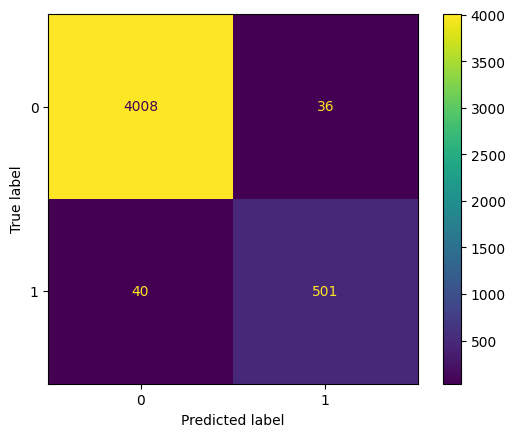

In [42]:
confmatrix_clean = confusion_matrix(y_test_clean, y_pred_clean)
ConfusionMatrixDisplay(confusion_matrix=confmatrix_clean).plot()

A tisztított adatokon természetesen a modell sokat javult. Az outlierek eltüntetése és az egyes osztályok aránytalanságának kisméretű csökkenése mindegyik mutatót jelentős javulását okozta.

Itt azonban még mindig problémának gondolom, hogy az a 40 eset, aminek a valós cimkéje pulzár, de zajnak ismerte fel a modell, az gondot jelent, mert ez majdnem 10%-az értékes adatoknak.

In [43]:
dot_data = export_graphviz(dtc_clean, out_file=None,
                      feature_names=feature_cimkek,
                      class_names=["Died", "Survived"],
                      filled=True,
                      rounded=True,
                      special_characters=True)
graph = graphviz.Source(dot_data)
#graph

## Logisztikus regresszió

A logisztikus regresszió jó választás lehet az adathalmaz tekintetében osztályozási feladatra, mert az osztálycimkék kétértékűek, a változók folytonos változók és valószínűséget ad, nem csak kategóriákat. A viszont gondot fog okozni a modellnek, hogy a diszperzitás adatok között (DM_*) nagyon erős a multikollinearitás és a Profile_* adatok közt is több helyen ez problémát jelent. Ezért az l1 regularizációt fogom használni.

In [149]:
lr = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced', penalty='l1')
lr.fit(X_train_clean, y_train_clean["class"])
y_pred_lr = lr.predict(X_test_clean)
print(classification_report(y_test_clean, y_pred_lr))
print("Accuracy:", accuracy_score(y_test_clean, y_pred_lr))
print("Sensitivity:", recall_score(y_test_clean, y_pred_lr))
print("Specificity:", recall_score(y_test_clean, y_pred_lr, pos_label=0))
print("F1:", f1_score(y_test_clean, y_pred_lr))
print("AUC:", roc_auc_score(y_test_clean, y_pred_lr))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      4044
           1       0.82      0.93      0.87       541

    accuracy                           0.97      4585
   macro avg       0.90      0.95      0.93      4585
weighted avg       0.97      0.97      0.97      4585

Accuracy: 0.9672846237731734
Sensitivity: 0.933456561922366
Specificity: 0.9718100890207715
F1: 0.8706896551724138
AUC: 0.9526333254715686


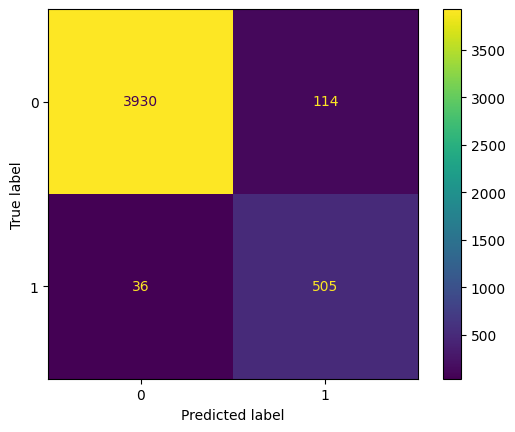

In [150]:
confmatrix_clean_lr = confusion_matrix(y_test_clean, y_pred_lr)
ConfusionMatrixDisplay(confusion_matrix=confmatrix_clean_lr).plot()

A false negativ ertekek itt a legkisebbek eddig, de a probléma az, hogy nagyon megugrott a false pozitív értékek száma.

## Random forest

Mivel ez sok döntési fa szavazata alapján dönt ("ensemble" módszer), kiválóan kezeli a pulzárokra jellemző zajos adatokat és a kiugró értékeket anélkül, hogy túlságosan megtanulná a hibákat (overfitting). A páros diagramokon láttuk, hogy az összefüggések bonyolultak és nem mindig egyenesek; a Random Forest képes ezeket a nem-lineáris mintázatokat is lekövetni.

In [154]:
rfc = RandomForestClassifier(n_estimators=1000, criterion="gini", class_weight="balanced")
rfc.fit(X_train_clean, y_train_clean["class"])
y_pred_rfc = rfc.predict(X_test_clean)
print(classification_report(y_test_clean, y_pred_rfc))
print("Accuracy:", accuracy_score(y_test_clean, y_pred_rfc))
print("Sensitivity:", recall_score(y_test_clean, y_pred_rfc))
print("Specificity:", recall_score(y_test_clean, y_pred_rfc, pos_label=0))
print("F1:", f1_score(y_test_clean, y_pred_rfc))
print("AUC:", roc_auc_score(y_test_clean, y_pred_rfc))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4044
           1       1.00      0.93      0.96       541

    accuracy                           0.99      4585
   macro avg       0.99      0.96      0.98      4585
weighted avg       0.99      0.99      0.99      4585

Accuracy: 0.9912758996728462
Sensitivity: 0.9297597042513863
Specificity: 0.9995054401582592
F1: 0.9617590822179732
AUC: 0.9646325722048228


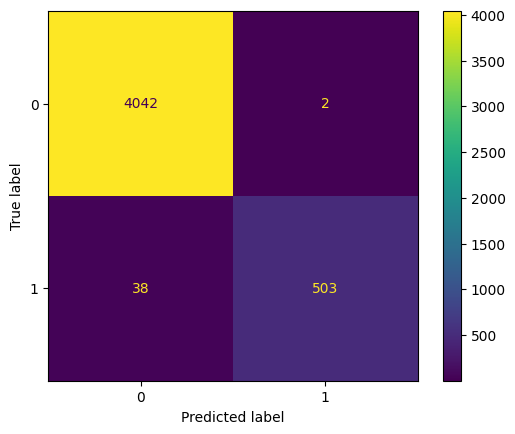

In [155]:
confmatrix_clean_rfc = confusion_matrix(y_test_clean, y_pred_rfc)
ConfusionMatrixDisplay(confusion_matrix=confmatrix_clean_rfc).plot()

A false negatívok száma az előbbi két modell közé esett, de a false pozitívok száma kiemelkedően jónak tűnik.

## Support vector machine

A Profile_kurtosis és skewness ábráin látszott, hogy a pulzárok egy jól körülhatárolható, de szabálytalan alakú "szigetet" alkotnak, az SVM  az ilyen szigetszerű elkülönülések megtalálásában segíthet. A probléma az, hogy érzékeny az összefüggő adatokra, ezt kézzel kezelem a leginkább korreláló oszlopok eltávolításával.

In [138]:
feature_cimkek

['Profile_mean',
 'Profile_stdev',
 'Profile_skewness',
 'Profile_kurtosis',
 'DM_mean',
 'DM_stdev',
 'DM_skewness',
 'DM_kurtosis']

In [146]:
feature_cimkek_svm = ['Profile_mean',
 'Profile_stdev',
 'Profile_skewness',
 'Profile_kurtosis',
 'DM_mean',
 'DM_stdev',
 'DM_skewness',
 'DM_kurtosis']

In [147]:
svcl = SVC(kernel='rbf', class_weight='balanced', probability=True)
svcl.fit(X_train_clean[feature_cimkek_svm], y_train_clean["class"])
y_pred_svcl = svcl.predict(X_test_clean[feature_cimkek_svm])
print(classification_report(y_test_clean, y_pred_svcl))
print("Accuracy:", accuracy_score(y_test_clean, y_pred_svcl))
print("Sensitivity:", recall_score(y_test_clean, y_pred_svcl))
print("Specificity:", recall_score(y_test_clean, y_pred_svcl, pos_label=0))
print("F1:", f1_score(y_test_clean, y_pred_svcl))
print("AUC:", roc_auc_score(y_test_clean, y_pred_svcl))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4044
           1       0.98      0.93      0.95       541

    accuracy                           0.99      4585
   macro avg       0.98      0.97      0.97      4585
weighted avg       0.99      0.99      0.99      4585

Accuracy: 0.9895310796074155
Sensitivity: 0.933456561922366
Specificity: 0.9970326409495549
F1: 0.9546313799621928
AUC: 0.9652446014359605


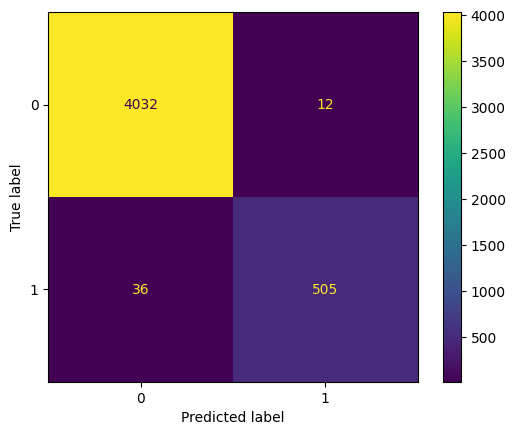

In [148]:
confmatrix_clean_svcl = confusion_matrix(y_test_clean, y_pred_svcl)
ConfusionMatrixDisplay(confusion_matrix=confmatrix_clean_svcl).plot()

Többé kevésbé alapbeállítások mellett ez a modell sem szerepelt rosszul. A fals negatívok száma a legkisebb, a false pozitívok száma peidg elfogadható szinten van.

## Modellek összehasonlítása

A kiegyensúlyozatlan adathalmaz miatt a Precision-Recall görbét használom.

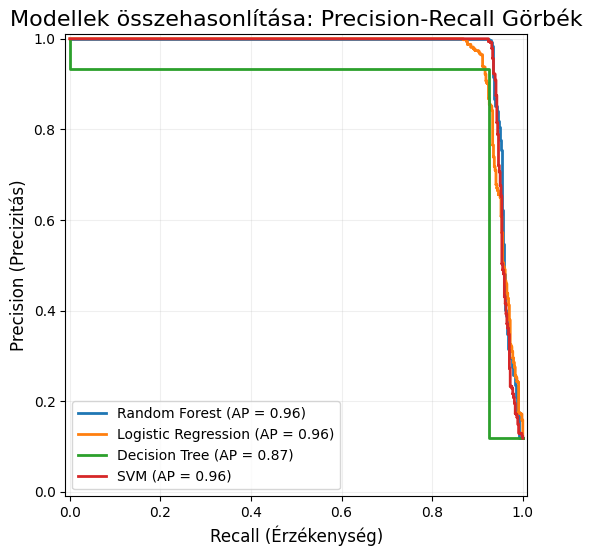

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

models = [
    (rfc, "Random Forest"),
    (lr, "Logistic Regression"),
    (dtc_clean, "Decision Tree"),
    (svcl, "SVM"),
]

for model_object, model_name in models:
    PrecisionRecallDisplay.from_estimator(
        estimator=model_object,
        X=X_test_clean,
        y=y_test_clean,
        name=model_name,
        ax=ax,
        linewidth=2
    )

plt.title("Modellek összehasonlítása: Precision-Recall Görbék", fontsize=16)
plt.xlabel("Recall (Érzékenység)", fontsize=12)
plt.ylabel("Precision (Precizitás)", fontsize=12)
plt.legend(loc="best", fontsize=10)
plt.grid(True, alpha=0.2)
plt.show()

Az nem meglepő hogy a döntési fa szerepelt a legrosszabbul. A Random forest és az SVM a legjobb választás, mert precision gyakorlatilag egyen tartása mellett a legmagasabb recall értéket tudták elérni.

## Hyperparaméterek hangolása

A fenti alap tesztekben jól szereplő SVM és Random Forest közül a random forestet választottam a hyper paraméter hangolásra, mert sokféle paramétert lehet hangolni. A futásidők és a számítási erőforrás hiányában csak a RandomizedSearchCV-t fogom használni.

Scoringnak az average_precision-t választottam, mivel szeretnék a pozitív osztályra (pulzár) és a téves riasztásokra koncentrálni. A "szénakazlat" (a rengeteg helyesen felismert zajt) ez teljesen figyelmen kívül hagyja.

In [172]:
dtc_opt = RandomForestClassifier(random_state=42, class_weight="balanced")
params = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': range(100, 1000),
    'max_depth': range(1, 25),
    'min_samples_split': range(2, 20),
    'min_samples_leaf': range(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=dtc_opt,
    param_distributions=params,
    n_iter=50,
    cv=5,
    scoring='average_precision',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search_results = random_search.fit(X_train_clean, y_train_clean["class"])

print(f"Legjobb paraméterek: {random_search.best_params_}")
print(f"Legjobb Average Precision score (Train CV): {random_search.best_score_:.4f}")

best_rf_model = random_search.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=288; total time=   0.7s
[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=288; total time=   0.7s
[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=288; total time=   0.7s
[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=288; total time=   0.7s
[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=288; total time=   0.7s
[CV] END bootstrap=True, criterion=entropy, max_depth=7, max_features=log2, min_samples_leaf=3, min_samples_split=18, n_estimators=592; total time=   7.2s
[CV] END bootstrap=True

In [209]:
y_pred_rfc_best = best_rf_model.predict(X_test_clean)
print(classification_report(y_test_clean, y_pred_rfc_best))
print("Accuracy:", accuracy_score(y_test_clean, y_pred_rfc_best))
print("Sensitivity:", recall_score(y_test_clean, y_pred_rfc_best))
print("Specificity:", recall_score(y_test_clean, y_pred_rfc_best, pos_label=0))
print("F1:", f1_score(y_test_clean, y_pred_rfc_best))
print("AUC:", roc_auc_score(y_test_clean, y_pred_rfc_best))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4044
           1       0.99      0.93      0.96       541

    accuracy                           0.99      4585
   macro avg       0.99      0.97      0.98      4585
weighted avg       0.99      0.99      0.99      4585

Accuracy: 0.9910577971646674
Sensitivity: 0.9316081330868762
Specificity: 0.9990108803165183
F1: 0.9609151572926596
AUC: 0.9653095067016972


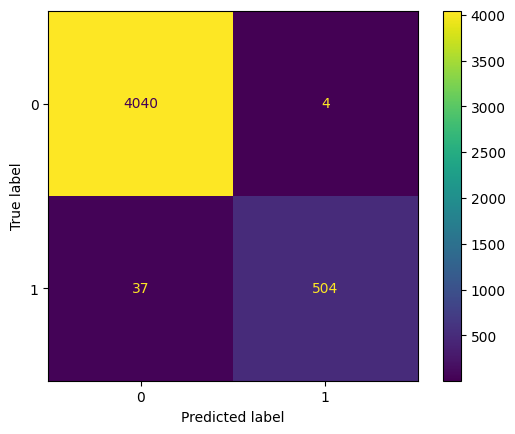

In [210]:
confmatrix_clean_best_rfc = confusion_matrix(y_test_clean, y_pred_rfc_best)
ConfusionMatrixDisplay(confusion_matrix=confmatrix_clean_best_rfc).plot()

# Jellemzők szelekciója

In [177]:
perm_importance = permutation_importance(
    best_rf_model, 
    X_test_clean,
    y_test_clean, 
    n_repeats=10, 
    random_state=42, 
    scoring='average_precision'
)

sorted_idx = perm_importance.importances_mean.argsort()

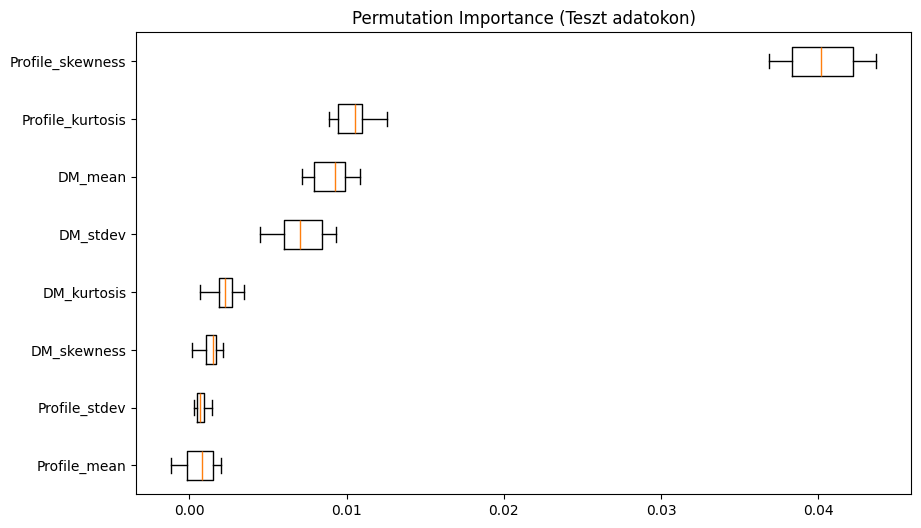

In [179]:
plt.figure(figsize=(10, 6))
plt.boxplot(
    perm_importance.importances[sorted_idx].T,
    vert=False,
    tick_labels=X_test_clean.columns[sorted_idx]
)
plt.title("Permutation Importance (Teszt adatokon)")
plt.show()

A Permutation Importance (permutációs fontosság) azt mutatja meg, hogy mennyit romlana a modell pontossága, ha az adott változót véletlenszerűen összekevernénk.
- A **Profile_skewness** változó toronymagasan vezet. A fontossága (~0.04) sokszorosa a többinek. Tehát a modell szerint a legfontosabb dolog, ami megkülönbözteti a pulzárt a zajtól, az a jel profiljának aszimmetriája (ferdesége).
- A **Profile_kurtosis, DM_mean, DM_stdev** változóknak mérhető, pozitív hatása van a modellre (kb. 0.01 körüli értékek). Feltehetően a Profile_kurtosis (csúcsosság) megerősíti a ferdeséget, a DM (Diszperzió) változók pedig segítenek eldönteni, hogy a jel távolról jön-e.
- A **Profile_mean, Profile_stdev, DM_skewness, DM_kurtosis** változók fontossága a 0 közelében van, sőt, a bajszok be is lógnak a negatív tartományba (vagy éppen csak súrolják a nullát). Tehát ha ezeket az oszlopokat véletlenszerű zajjal helyettesíteném, a modell pontossága szinte semmit sem változna.

A Profile_mean és Profile_stdev szinte biztosan elhagyható a modellből. De elég valószínű, hogy a DM_kurtosis és a DM_skewness is.

## 2 eltávolított feature

Profile_mean, Profile_stdev

In [180]:
feature_cimkek

['Profile_mean',
 'Profile_stdev',
 'Profile_skewness',
 'Profile_kurtosis',
 'DM_mean',
 'DM_stdev',
 'DM_skewness',
 'DM_kurtosis']

In [182]:
feature_cimkek_opt_2 = ['Profile_skewness',
 'Profile_kurtosis',
 'DM_mean',
 'DM_stdev',
 'DM_skewness',
 'DM_kurtosis']

In [183]:
dtc_opt = RandomForestClassifier(random_state=42, class_weight="balanced")
params = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': range(100, 1000),
    'max_depth': range(1, 25),
    'min_samples_split': range(2, 20),
    'min_samples_leaf': range(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=dtc_opt,
    param_distributions=params,
    n_iter=50,
    cv=5,
    scoring='average_precision',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search_results = random_search.fit(X_train_clean[feature_cimkek_opt_2], y_train_clean["class"])

print(f"Legjobb paraméterek: {random_search.best_params_}")
print(f"Legjobb Average Precision score (Train CV): {random_search.best_score_:.4f}")

best_rf_model_2 = random_search.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=288; total time=   0.7s
[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=288; total time=   0.7s
[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=288; total time=   0.7s
[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=288; total time=   0.7s
[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=288; total time=   0.8s
[CV] END bootstrap=True, criterion=entropy, max_depth=7, max_features=log2, min_samples_leaf=3, min_samples_split=18, n_estimators=592; total time=   4.8s
[CV] END bootstrap=True

A korábbi paraméter hangolás eredménye:
- Legjobb paraméterek: {'n_estimators': 577, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 7, 'criterion': 'entropy', 'bootstrap': True}
- Legjobb Average Precision score (Train CV): 0.9690

Az új paraméterek:
- Legjobb paraméterek: {'n_estimators': 592, 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': 7, 'criterion': 'entropy', 'bootstrap': True}
- Legjobb Average Precision score (Train CV): 0.9693

In [211]:
y_pred_rfc_best_2 = best_rf_model_2.predict(X_test_clean[feature_cimkek_opt_2])
print(classification_report(y_test_clean, y_pred_rfc_best_2))
print("Accuracy:", accuracy_score(y_test_clean, y_pred_rfc_best_2))
print("Sensitivity:", recall_score(y_test_clean, y_pred_rfc_best_2))
print("Specificity:", recall_score(y_test_clean, y_pred_rfc_best_2, pos_label=0))
print("F1:", f1_score(y_test_clean, y_pred_rfc_best_2))
print("AUC:", roc_auc_score(y_test_clean, y_pred_rfc_best_2))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4044
           1       0.99      0.93      0.96       541

    accuracy                           0.99      4585
   macro avg       0.99      0.97      0.98      4585
weighted avg       0.99      0.99      0.99      4585

Accuracy: 0.9908396946564886
Sensitivity: 0.9316081330868762
Specificity: 0.9987636003956478
F1: 0.96
AUC: 0.965185866741262


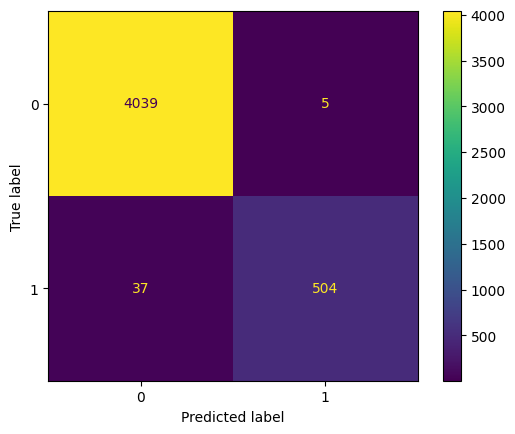

In [213]:
confmatrix_clean_best_rfc = confusion_matrix(y_test_clean, y_pred_rfc_best_2)
ConfusionMatrixDisplay(confusion_matrix=confmatrix_clean_best_rfc).plot()

A modell eredményei semmit nem változtak, ami számomra azt jelenti, hogy ez a két feature biztosan elhagyható.

## 4 eltávolított feature

Profile_mean, Profile_stdev, DM_skewness, DM_kurtosis eltávolítása

In [190]:
feature_cimkek

['Profile_mean',
 'Profile_stdev',
 'Profile_skewness',
 'Profile_kurtosis',
 'DM_mean',
 'DM_stdev',
 'DM_skewness',
 'DM_kurtosis']

In [ ]:
feature_cimkek_opt_4 = ['Profile_skewness',
 'Profile_kurtosis',
 'DM_mean',
 'DM_stdev']

In [192]:
dtc_opt = RandomForestClassifier(random_state=42, class_weight="balanced")
params = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': range(100, 1000),
    'max_depth': range(1, 25),
    'min_samples_split': range(2, 20),
    'min_samples_leaf': range(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=dtc_opt,
    param_distributions=params,
    n_iter=50,
    cv=5,
    scoring='average_precision',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search_results = random_search.fit(X_train_clean[feature_cimkek_opt_4], y_train_clean["class"])

print(f"Legjobb paraméterek: {random_search.best_params_}")
print(f"Legjobb Average Precision score (Train CV): {random_search.best_score_:.4f}")

best_rf_model_4 = random_search.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=288; total time=   0.8s
[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=288; total time=   0.7s
[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=288; total time=   0.8s
[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=288; total time=   0.8s
[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=288; total time=   0.8s
[CV] END bootstrap=True, criterion=entropy, max_depth=7, max_features=log2, min_samples_leaf=3, min_samples_split=18, n_estimators=592; total time=   5.1s
[CV] END bootstrap=True

Paraméter hangolás eredménye az összes feature-el:
- Legjobb paraméterek: {'n_estimators': 577, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 7, 'criterion': 'entropy', 'bootstrap': True}
- Legjobb Average Precision score (Train CV): 0.9690

Paraméter hangolás eredménye két feature elhagyásával:
- Legjobb paraméterek: {'n_estimators': 592, 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': 7, 'criterion': 'entropy', 'bootstrap': True}
- Legjobb Average Precision score (Train CV): 0.9693

Paraméter hangolás eredménye négy feature elhagyásával:
- Legjobb paraméterek: {'n_estimators': 288, 'min_samples_split': 18, 'min_samples_leaf': 6, 'max_features': 'log2', 'max_depth': 6, 'criterion': 'gini', 'bootstrap': True}
- Legjobb Average Precision score (Train CV): 0.9688

In [214]:
y_pred_rfc_best_4 = best_rf_model_4.predict(X_test_clean[feature_cimkek_opt_4])
print(classification_report(y_test_clean, y_pred_rfc_best_4))
print("Accuracy:", accuracy_score(y_test_clean, y_pred_rfc_best_4))
print("Sensitivity:", recall_score(y_test_clean, y_pred_rfc_best_4))
print("Specificity:", recall_score(y_test_clean, y_pred_rfc_best_4, pos_label=0))
print("F1:", f1_score(y_test_clean, y_pred_rfc_best_4))
print("AUC:", roc_auc_score(y_test_clean, y_pred_rfc_best_4))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4044
           1       0.97      0.93      0.95       541

    accuracy                           0.99      4585
   macro avg       0.98      0.96      0.97      4585
weighted avg       0.99      0.99      0.99      4585

Accuracy: 0.9888767720828789
Sensitivity: 0.9297597042513863
Specificity: 0.9967853610286844
F1: 0.9517502365184485
AUC: 0.9632725326400354


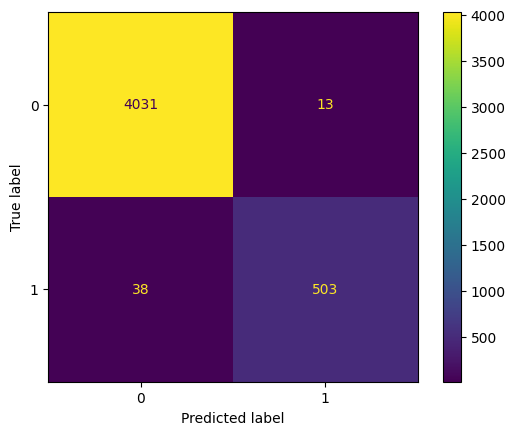

In [215]:
confmatrix_clean_best_rfc = confusion_matrix(y_test_clean, y_pred_rfc_best_4)
ConfusionMatrixDisplay(confusion_matrix=confmatrix_clean_best_rfc).plot()

Az eredmények azt mutatják, hogy a 4 featuret együtt már nem célszerű eltávolítani, mert kissé romlik a modell. Azonban olyan szempontból ez egy jó modell, hogy viszonylag könnyű értelmezni a megmaradt cimkéket: arra, hogy a jel pulzár vagy zaj, a jel alakjának csúcsossága és eltoltsága illetve a zaj átlagos értéke és szórása alapján lehet eldönteni. A "Profil" pár (Profile_skewness, Profile_kurtosis) azt vizsgálja, MILYEN a jel alakja, míg a "DM" pár (DM_mean, DM_stdev) azt vizsgálja, honnan jön a jel (az űrből vagy a Földről).

## Szekvenciális feature szelekció

In [ ]:
dtc_opt = RandomForestClassifier(
    random_state=42, 
    class_weight="balanced", 
    n_estimators = 577, 
    min_samples_split = 2,
    min_samples_leaf = 5,
    max_features = "sqrt",
    max_depth = 7,
    criterion = "entropy",
    bootstrap = True)

sfs = SFS(dtc_opt,
          k_features = 'best',
          forward = False,
          floating = True,
          scoring = 'average_precision',
          cv = 10,
          n_jobs = -1)
sfs = sfs.fit(X_train_clean, y_train_clean["class"])

print('Sequential forward selection (%i features): ' % np.size(sfs.k_feature_idx_)) # a kiválasztott tulajdonságok száma
print('A választott tulajdosnágok indexe: ', sfs.k_feature_idx_)
print('CV score: ', sfs.k_score_)

Sequential forward selection (6 features): 
A választott tulajdosnágok indexe:  (0, 2, 3, 4, 5, 6)
CV score:  0.9692937411621276


In [242]:
feature_cimkek_sfs = [feature_cimkek[i] for i in sfs.k_feature_idx_]
feature_cimkek_sfs

['Profile_mean',
 'Profile_skewness',
 'Profile_kurtosis',
 'DM_mean',
 'DM_stdev',
 'DM_skewness']

In [243]:
dtc_opt = RandomForestClassifier(random_state=42, class_weight="balanced")
params = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': range(100, 1000),
    'max_depth': range(1, 25),
    'min_samples_split': range(2, 20),
    'min_samples_leaf': range(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=dtc_opt,
    param_distributions=params,
    n_iter=50,
    cv=5,
    scoring='average_precision',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search_results = random_search.fit(X_train_clean[feature_cimkek_sfs], y_train_clean["class"])

print(f"Legjobb paraméterek: {random_search.best_params_}")
print(f"Legjobb Average Precision score (Train CV): {random_search.best_score_:.4f}")

best_rf_model_sfs = random_search.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=288; total time=   0.6s
[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=288; total time=   0.7s
[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=288; total time=   0.7s
[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=288; total time=   0.7s
[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=288; total time=   0.8s
[CV] END bootstrap=True, criterion=entropy, max_depth=7, max_features=log2, min_samples_leaf=3, min_samples_split=18, n_estimators=592; total time=   5.0s
[CV] END bootstrap=True

In [245]:
y_pred_rfc_best_sfs = best_rf_model_sfs.predict(X_test_clean[feature_cimkek_sfs])
print(classification_report(y_test_clean, y_pred_rfc_best_sfs))
print("Accuracy:", accuracy_score(y_test_clean, y_pred_rfc_best_sfs))
print("Sensitivity:", recall_score(y_test_clean, y_pred_rfc_best_sfs))
print("Specificity:", recall_score(y_test_clean, y_pred_rfc_best_sfs, pos_label=0))
print("F1:", f1_score(y_test_clean, y_pred_rfc_best_sfs))
print("AUC:", roc_auc_score(y_test_clean, y_pred_rfc_best_sfs))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4044
           1       0.99      0.93      0.96       541

    accuracy                           0.99      4585
   macro avg       0.99      0.97      0.98      4585
weighted avg       0.99      0.99      0.99      4585

Accuracy: 0.9906215921483097
Sensitivity: 0.9316081330868762
Specificity: 0.9985163204747775
F1: 0.9590865842055185
AUC: 0.9650622267808269


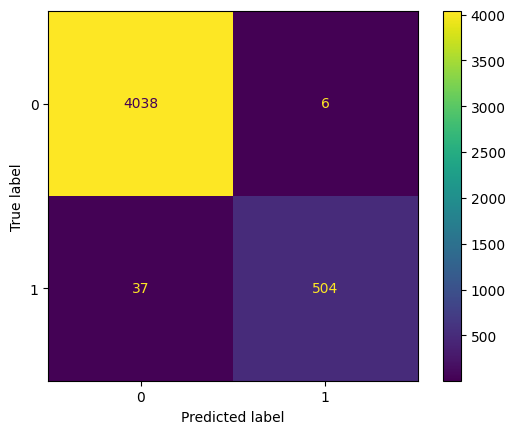

In [246]:
confmatrix_clean_best_rfc = confusion_matrix(y_test_clean, y_pred_rfc_best_sfs)
ConfusionMatrixDisplay(confusion_matrix=confmatrix_clean_best_rfc).plot()